# ANALYZE BIOMODELS SUBNETS

In [55]:
import pySubnetSB.constants as cn
from pySubnetSB.network import Network

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import tellurium as te
from typing import List, Optional, Union

# Data Preparation

In [2]:
#PATH = os.path.join(cn.PROJECT_DIR, "biomodels_subnets.csv")
STRONG_DF = pd.read_csv(cn.SUBNET_BIOMODELS_STRONG_PATH).sort_values([cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME])
STRONG_DF = STRONG_DF.reset_index()
WEAK_DF = pd.read_csv(cn.SUBNET_BIOMODELS_WEAK_PATH).sort_values([cn.FINDER_REFERENCE_NAME, cn.FINDER_TARGET_NAME])
SUMMARY_DF = pd.read_csv(cn.BIOMODELS_SUMMARY_PATH).sort_values(cn.D_MODEL_NAME)
WEAK_DF = WEAK_DF.reset_index()

In [3]:
STRONG_DF.head()

,index,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong,truncated_strong,probability_of_occurrence_weak,trunceated_weak,estimated_poc_strong,estimated_poc_weak
0,854,BIOMD0000000006,BIOMD0000000067,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","63242: 4 species, 3 reactions\n V_Pta: AcCoA ...","{""species_names"": {""EmptySet"": ""AcCoA"", ""u"": ""...",15.0,False,NaN,NaN,NaN,NaN,0.0,0.0
1,703,BIOMD0000000006,BIOMD0000000715,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","2006010: 4 species, 3 reactions\n reaction_3:...","{""species_names"": {""EmptySet"": ""S"", ""u"": ""I"", ...",6.0,False,NaN,NaN,NaN,NaN,0.0,0.0
2,298,BIOMD0000000006,BIOMD0000000848,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","9239969: 4 species, 3 reactions\n Uninfected_...","{""species_names"": {""EmptySet"": ""T"", ""u"": ""R"", ...",18.0,False,NaN,NaN,NaN,NaN,0.0,0.0
3,793,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","4369297: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24.0,False,0.0,0.0,0.0,0.0,0.0,0.0
4,1029,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","3434857: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60.0,False,0.0,0.0,0.0,0.0,0.0,0.0


In [4]:
WEAK_DF.head()

,index,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong,truncated_strong,probability_of_occurrence_weak,trunceated_weak,estimated_poc_strong,estimated_poc_weak
0,1301,BIOMD0000000006,BIOMD0000000067,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","7954902: 4 species, 3 reactions\n V_Pta: AcCo...","{""species_names"": {""EmptySet"": ""AcCoA"", ""u"": ""...",15.0,False,NaN,NaN,NaN,NaN,0.0,0.0
1,1218,BIOMD0000000006,BIOMD0000000715,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","7360183: 4 species, 3 reactions\n reaction_3:...","{""species_names"": {""EmptySet"": ""S"", ""u"": ""I"", ...",6.0,False,NaN,NaN,NaN,NaN,0.0,0.0
2,782,BIOMD0000000006,BIOMD0000000848,"BIOMD0000000006: 4 species, 3 reactions\n Rea...","7617882: 4 species, 3 reactions\n Uninfected_...","{""species_names"": {""EmptySet"": ""T"", ""u"": ""R"", ...",18.0,False,NaN,NaN,NaN,NaN,0.0,0.0
3,0,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","8615539: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24.0,False,0.0,0.0,0.0,0.0,0.0,0.0
4,945,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","3682315: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60.0,False,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
SUMMARY_DF.head()

,model_name,num_reaction,num_species,trunceated_weak,truncated_strong,is_boundary_network,probability_of_occurrence_strong,probability_of_occurrence_weak
880,BIOMD0000000001,17,12,NaN,NaN,False,NaN,NaN
430,BIOMD0000000002,17,13,NaN,NaN,False,NaN,NaN
915,BIOMD0000000003,7,3,0.0,0.0,True,0.0,0.0
115,BIOMD0000000004,7,5,0.0,0.0,False,0.0,0.0
520,BIOMD0000000005,9,9,0.0,0.0,False,0.0,0.0


In [6]:
def makeMergeColumnName(column:str, is_reference:bool=True)->str:
    """
    Creates column names for merged result of subnet dataframe with summary dataframe.
    """
    if is_reference:
        suffix = "_reference"
    else:
        suffix = "_induced"
    return column + "_reference"

In [7]:
# Augment the subnet information with the reference num_reaction, num_species
def mergeWithSummary(subnet_df:pd.DataFrame=STRONG_DF)->pd.DataFrame:
    """
    Augment the subnet dataframe with summary information for reference network.
    """
    df = subnet_df.merge(SUMMARY_DF, right_on='model_name', left_on='reference_name',
                        suffixes=["_induced", "_reference"])
    df = df.reset_index()
    del df['index']
    drops = df['reference_name'] == 'something'
    df = df[~drops]
    df = df.reset_index()
    return df
#
df = mergeWithSummary()
assert(len([c for c in df.columns if "_reference" in c]) > 0)
assert(len([c for c in df.columns if "_induced" in c]) > 0)
assert(len(df) <= len(STRONG_DF))
print("OK!")

OK!


In [8]:
STRONG_DF = mergeWithSummary(STRONG_DF)
WEAK_DF = mergeWithSummary(WEAK_DF)

## Check for duplicates

**REMOVE DUPLICATES**

# Helpers

In [9]:
def makeTestDataFrame():
    df = pd.DataFrame({'reference_name': [0, 1, 1, 2, 2, 2], 'target_name': [0, 1, 1, 2, 2, 2]})
    return df.astype(str)
TEST_NUM_DUPLICATE = 5

In [10]:
def makeAntimony(model_name:str, is_reference:bool=True, subnet_df:pd.DataFrame=STRONG_DF, is_roadrunner_loadable:bool=False):
    """
    Transforms the string in a "network" cell into an antimony model
    """
    if is_reference:
        name_col = 'reference_name'
        network_col = 'reference_network'
    else:
        name_col = 'target_name'
        network_col = 'induced_network'
    models =  subnet_df[subnet_df[name_col] == model_name][network_col].values
    if len(models) == 0:
        return None
    model = models[0]
    if is_roadrunner_loadable:
        pos = model.index('tions\n')
        model = model[pos+7:]
        model = model.replace('\n', ';1\n')
        model += ";1;"
    return model

# TESTS
model = makeAntimony('BIOMD0000000224', is_roadrunner_loadable=True)
rr = te.loada(model)
model = makeAntimony('BIOMD0000000030')
assert(model is None)
print("OK!")

OK!


In [11]:
def extractBiomodelNum(stg:str)->int:
    """
    Extracts the number from the biomodels name.
    """
    substg = stg[5:]
    pos = np.min([n if c != '0' else 1000 for n, c in enumerate(substg)])
    try:
        result = int(substg[pos:])
    except:
        result = None
    return result

# TESTS
num = extractBiomodelNum('BIOMD0000000030')
assert(num == 30)
num = extractBiomodelNum('BIOMD0000002030')
assert(num == 2030)
print("OK!")

OK!


In [12]:
def checkDuplicates(df:pd.DataFrame, is_print:bool=True)->list:
    """
    Checks if elements are duplicated
    """
    keys = list(df['reference_name'] + df['target_name'])
    duplicates = []
    if len(keys) > len(set(keys)):
        duplicates = [k for k in keys if keys.count(k) > 1]
        if is_print:
            print(f"**Duplicate entries: {duplicates}")
    else:
        if is_print:
            print("**No duplicate entries")
    return duplicates

count = len(checkDuplicates(makeTestDataFrame(), is_print=False))
assert(count == TEST_NUM_DUPLICATE)
print("OK!")

OK!


In [13]:
def removeDuplicates(df:pd.DataFrame)->pd.DataFrame:
    """
    Remove rows where the reference_name + target_name is duplicated.

    Args:
        df: dataframe procesed

    Returns:
        DataFrame w/o duplicates
    """
    keys = np.array(df['reference_name'].astype(str) + df['target_name'].astype(str))
    all_positions = np.array(range(len(keys)))
    drop_idxs = []
    for key in set(keys):
        key_positions = all_positions[keys == key]
        drop_idxs.extend(key_positions[:-1])
    result_df = df.drop(drop_idxs)
    return result_df

# TESTS
df = makeTestDataFrame()
result_df = removeDuplicates(df)
assert(len(result_df) == 3)
print("OK!")   

OK!


In [14]:
def getTargetNames(reference_name:str, subnet_df:pd.DataFrame=STRONG_DF)->List[str]:
    """
    Gets the list of target names for the reference, if any.

    Args:
       reference_name: str

    Returns:
       list-str
    """
    sel = subnet_df["reference_name"] == reference_name
    if np.sum(sel) == 0:
        return None
    target_names = subnet_df[sel]["target_name"].values
    return target_names

# Tests
names = getTargetNames("BIOMD0000000224")
assert(len(names) > 0)
names = getTargetNames("BIOMD000000022x")
assert(names is None)
print("OK!")

OK!


In [60]:
def calculateLog10Probability(prob:Union[float, np.ndarray], min_prob=1e-5)->np.ndarray:
    """
    Calculates -Log10 of probabilities
    """
    if isinstance(prob, float) or isinstance(prob, int):
        new_prob = max(prob, min_prob)
    else:
        new_prob = np.array([max(v, min_prob) for v in prob])
    return -np.log10(new_prob)
        

# Tess
result = calculateLog10Probability(0.4)
result = calculateLog10Probability(0)
assert(result == 5)
#
result = calculateLog10Probability([0.5, 0])
assert(result[1] == 5)
print("OK!")

OK!


# Probability of Occurrence of Reference Networks

Calculation of the POC of networks with weak and strong identity to the BioModels reference networks (those with number reactions <= 10)

In [15]:
# Heat map: x-num_species, y-num_reaction, color - POC or -log10 POC

In [16]:
pivot_df = SUMMARY_DF.pivot_table(values=cn.D_PROBABILITY_OF_OCCURRENCE_STRONG,
                                 index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES, aggfunc='median')
pivot_df

num_species,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
num_reaction,,,,,,,,,,,,,,,,,
1,0.098335,0.509080,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0.026775,0.005315,0.05749,0.007035,0.02144,0.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0.005510,0.002018,0.00026,0.002640,0.00000,0.000005,0.0,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0.001090,0.000260,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,0.000100,0.00006,0.000000,0.00000,0.000020,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,0.000010,0.00000,0.000000,0.00000,0.000000,0.0,0.0,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,0.000000,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,NaN,0.0,0.0,NaN,NaN,0.0,NaN
9,NaN,NaN,0.00000,0.000000,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,NaN,0.0,NaN,NaN,NaN,NaN


In [17]:
pivot_df = pivot_df.map(lambda x: max(x, 1e-5))
pivot_log10_df = pivot_df.map(lambda x: -np.log10(x))
pivot_log10_df

num_species,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
num_reaction,,,,,,,,,,,,,,,,,
1,1.007292,0.293214,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.572271,2.274497,1.240408,2.152736,1.668775,5.00000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.258848,2.695186,3.585027,2.578396,5.000000,5.00000,5.0,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2.962574,3.585027,5.000000,5.000000,5.000000,5.00000,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,4.000000,4.221849,5.000000,5.000000,4.69897,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,5.000000,5.000000,5.000000,5.000000,5.00000,5.0,5.0,NaN,5.0,5.0,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,5.000000,5.000000,5.000000,5.000000,5.00000,5.0,5.0,5.0,5.0,5.0,5.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,5.000000,5.000000,5.000000,5.00000,5.0,5.0,5.0,5.0,NaN,5.0,5.0,NaN,NaN,5.0,NaN
9,NaN,NaN,5.000000,5.000000,5.000000,5.00000,5.0,5.0,5.0,5.0,5.0,NaN,5.0,NaN,NaN,NaN,NaN


In [61]:
def plotModelPOC(is_strong:bool=True, is_plot:bool=True):
    if is_strong:
        column = cn.D_PROBABILITY_OF_OCCURRENCE_STRONG
        adjective = 'Strong'
    else:
        column = cn.D_PROBABILITY_OF_OCCURRENCE_WEAK
        adjective = 'Weak'
    pivot_df = SUMMARY_DF.pivot_table(values=column,
                    index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES, aggfunc='median')
    pivot_df = pivot_df.map(lambda x: calculateLog10Probability(x))
    pivot_df.sort_index(level=0, ascending=False, inplace=True)
    if is_plot:
        sns.heatmap(pivot_df, annot=True, fmt="1.1f", cmap="coolwarm", vmin=0, vmax=5,
              annot_kws={'size': 8},
              cbar_kws={'label': '-log10 Probability of occurrence'})
        plt.title(f"{adjective} Identity")
        plt.xlabel("number of species")
        plt.ylabel("number of reactions")
# Test
plotModelPOC(is_strong=True, is_plot=False)
print("OK!")

OK!


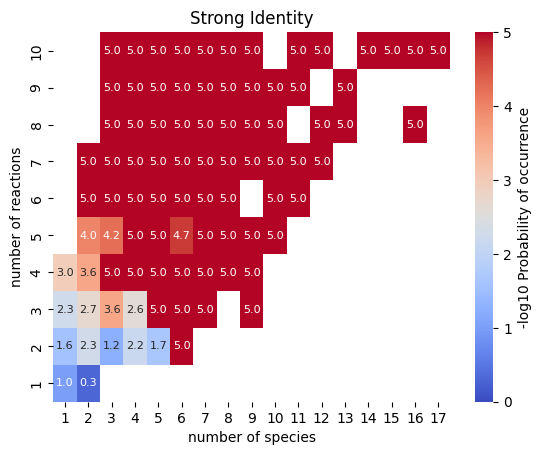

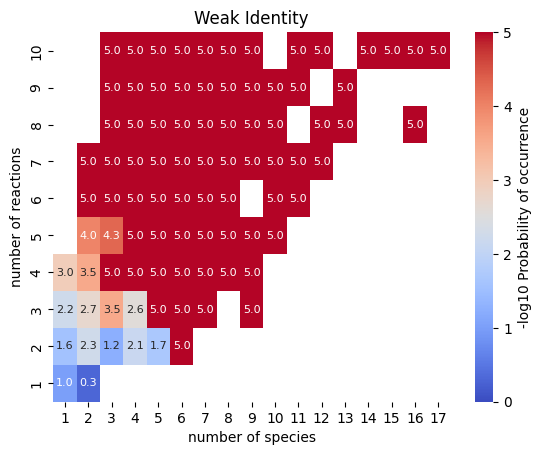

In [62]:
plotModelPOC(is_strong=True)
plt.figure()
plotModelPOC(is_strong=False)

In [64]:
STRONG_DF.columns

Index(['index', 'level_0', 'reference_name', 'target_name',
       'reference_network', 'induced_network', 'name_dct',
       'num_assignment_pair', 'is_truncated',
       'probability_of_occurrence_strong_induced', 'truncated_strong_induced',
       'probability_of_occurrence_weak_induced', 'trunceated_weak_induced',
       'estimated_poc_strong', 'estimated_poc_weak', 'model_name',
       'num_reaction', 'num_species', 'trunceated_weak_reference',
       'truncated_strong_reference', 'is_boundary_network',
       'probability_of_occurrence_strong_reference',
       'probability_of_occurrence_weak_reference'],
      dtype='object')

In [88]:
def heatmapPOC(df, column, title:str="", is_plot:bool=True):
    """
    Does a heatmap of probability of occurrence w.r.t. species and reactions.
    """
    pivot_df = df.pivot_table(values=column,
                    index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES, aggfunc='median')
    pivot_df = pivot_df.map(lambda x: calculateLog10Probability(x))
    pivot_df.sort_index(level=0, ascending=False, inplace=True)
    if is_plot:
        sns.heatmap(pivot_df, annot=True, fmt="1.1f", cmap="coolwarm", vmin=0, vmax=5,
              annot_kws={'size': 8},
              cbar_kws={'label': '-log10 Probability of occurrence'})
        plt.title(title)
        plt.xlabel("number of species")
        plt.ylabel("number of reactions")
# Test
heatmapPOC(STRONG_DF, 'probability_of_occurrence_strong_induced', title="Strong, Induced, POC", is_plot=False)
print("OK!")

OK!


OK!


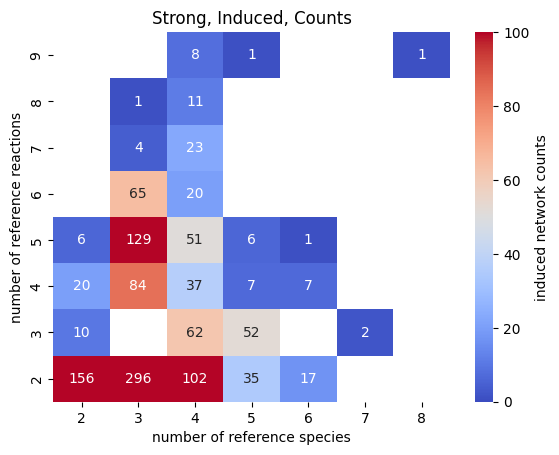

In [112]:
def heatmapCount(induced_df, title:str="", is_plot:bool=True):
    """
    Counts occurrences of induced networks.
    """
    ser = induced_df.groupby([cn.D_NUM_SPECIES, cn.D_NUM_REACTION]).count()['index']
    num_species = [x[0] for x in ser.index]
    num_reactions = [x[1] for x in ser.index]
    df = pd.DataFrame({cn.D_NUM_SPECIES: num_species, cn.D_NUM_REACTION: num_reactions, 'count': ser.values})
    pivot_df = df.pivot_table(values='count', index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES)
    pivot_df.sort_index(level=0, ascending=False, inplace=True)
    if is_plot:
        sns.heatmap(pivot_df, annot=True, fmt="1.0f", cmap="coolwarm", vmin=0, vmax=100,
              annot_kws={'size': 10},
              cbar_kws={'label': 'induced network counts'})
        plt.title(title)
        plt.xlabel("number of reference species")
        plt.ylabel("number of reference reactions")
# Test
heatmapCount(STRONG_DF, title="Strong, Induced, Counts", is_plot=True)
print("OK!")

In [105]:
ser = induced_df.groupby([cn.D_NUM_SPECIES, cn.D_NUM_REACTION]).count()['index']
num_species = [x[0] for x in ser.index]
num_reactions = [x[1] for x in ser.index]
df = pd.DataFrame({cn.D_NUM_SPECIES: num_species, cn.D_NUM_REACTION: num_reactions, 'count': ser.values})
pivot_df = df.pivot_table(values='count', index=cn.D_NUM_REACTION, columns=cn.D_NUM_SPECIES)
pivot_df

num_species,2,3,4,5,6,7,8
num_reaction,,,,,,,
2,156.0,296.0,102.0,35.0,17.0,NaN,NaN
3,10.0,NaN,62.0,52.0,NaN,2.0,NaN
4,20.0,84.0,37.0,7.0,7.0,NaN,NaN
5,6.0,129.0,51.0,6.0,1.0,NaN,NaN
6,NaN,65.0,20.0,NaN,NaN,NaN,NaN
7,NaN,4.0,23.0,NaN,NaN,NaN,NaN
8,NaN,1.0,11.0,NaN,NaN,NaN,NaN
9,NaN,NaN,8.0,1.0,NaN,NaN,1.0


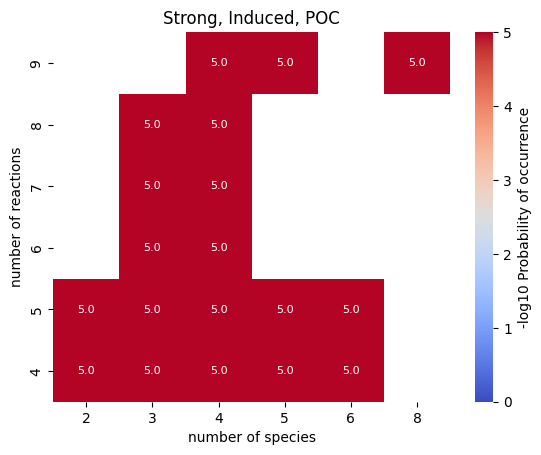

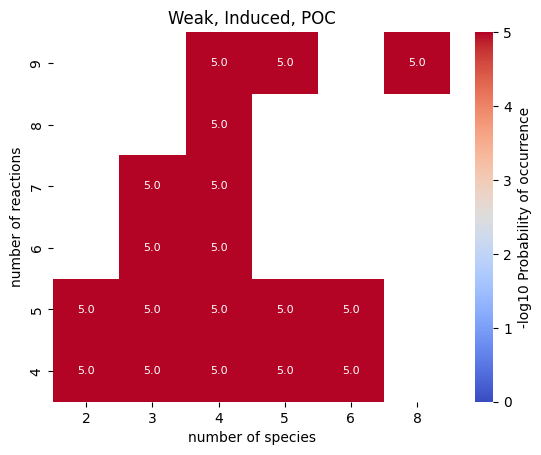

In [89]:
heatmapPOC(STRONG_DF, 'probability_of_occurrence_strong_induced', title="Strong, Induced, POC", is_plot=True)
plt.figure()
heatmapPOC(WEAK_DF, 'probability_of_occurrence_strong_induced', title="Weak, Induced, POC", is_plot=True)

In [81]:
sel = np.array([x > 3 and y >= 3 for x, y in zip(STRONG_DF['num_reaction'], STRONG_DF['num_species'])])
df = STRONG_DF[sel]
idxs = df['probability_of_occurrence_strong_induced'] > 0.001
np.sum(idxs), np.sum(sel), len(df)

(6, 456, 456)

In [76]:
df

,index,level_0,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong_induced,...,estimated_poc_strong,estimated_poc_weak,model_name,num_reaction,num_species,trunceated_weak_reference,truncated_strong_reference,is_boundary_network,probability_of_occurrence_strong_reference,probability_of_occurrence_weak_reference
3,3,3,BIOMD0000000027,BIOMD0000000170,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","4369297: 5 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",24.0,False,0.0,...,0.0,0.0,BIOMD0000000027,4,5,0.0,0.0,False,0.0,0.0
4,4,4,BIOMD0000000027,BIOMD0000000228,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","3434857: 5 species, 4 reactions\n pRB_phospho...","{""species_names"": {""M"": ""pRB"", ""Mp"": ""pRBp"", ""...",60.0,False,0.0,...,0.0,0.0,BIOMD0000000027,4,5,0.0,0.0,False,0.0,0.0
5,5,5,BIOMD0000000027,BIOMD0000000354,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","8670640: 5 species, 4 reactions\n JChannel: C...","{""species_names"": {""M"": ""CaS"", ""Mp"": ""CaI"", ""M...",12.0,False,0.0,...,0.0,0.0,BIOMD0000000027,4,5,0.0,0.0,False,0.0,0.0
6,6,6,BIOMD0000000027,BIOMD0000000355,"BIOMD0000000027: 5 species, 4 reactions\n v1:...","9365988: 5 species, 4 reactions\n mw1c50c3d1_...","{""species_names"": {""M"": ""mw013a7c64_a9ec_483c_...",60.0,False,0.0,...,0.0,0.0,BIOMD0000000027,4,5,0.0,0.0,False,0.0,0.0
7,7,7,BIOMD0000000031,BIOMD0000000170,"BIOMD0000000031: 6 species, 4 reactions\n v1:...","9726903: 6 species, 4 reactions\n BMAL1_nucle...","{""species_names"": {""M"": ""y5"", ""Mp"": ""y6"", ""Mpp...",48.0,False,0.0,...,0.0,0.0,BIOMD0000000031,4,6,0.0,0.0,False,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1123,1123,1123,BIOMD0000001035,BIOMD0000000352,"BIOMD0000001035: 4 species, 8 reactions\n uni...","8724268: 4 species, 8 reactions\n reac_prodI:...","{""species_names"": {""uninfected_cancer_cells"": ...",2.0,False,0.0,...,0.0,0.0,BIOMD0000001035,8,4,0.0,0.0,False,0.0,0.0
1124,1124,1124,BIOMD0000001035,BIOMD0000000539,"BIOMD0000001035: 4 species, 8 reactions\n uni...","8521646: 4 species, 8 reactions\n production_...","{""species_names"": {""uninfected_cancer_cells"": ...",4.0,False,0.0,...,0.0,0.0,BIOMD0000001035,8,4,0.0,0.0,False,0.0,0.0
1125,1125,1125,BIOMD0000001035,BIOMD0000000748,"BIOMD0000001035: 4 species, 8 reactions\n uni...","6259036: 4 species, 8 reactions\n tumor_growt...","{""species_names"": {""uninfected_cancer_cells"": ...",16.0,False,0.0,...,0.0,0.0,BIOMD0000001035,8,4,0.0,0.0,False,0.0,0.0
1126,1126,1126,BIOMD0000001043,BIOMD0000000058,"BIOMD0000001043: 4 species, 7 reactions\n uni...","2987077: 4 species, 7 reactions\n Jreceptor_C...","{""species_names"": {""uninfected_tumor_cells"": ""...",8.0,False,0.0,...,0.0,0.0,BIOMD0000001043,7,4,0.0,0.0,False,0.0,0.0


# POC of Induced Networks

In [34]:
# Scatter plot of subnets
def plotInducedByModelNumber(subnet_df:pd.DataFrame=STRONG_DF, significance:float=0.001, is_plot:bool=True,
      xlim:Optional[List]=None)->List[str]:
    """
    Scatter plot of reference vs. target by increasing model number filtered by the POC significance of the reference.
    """
    filtered_subnet_df = subnet_df [subnet_df[makeMergeColumnName(cn.D_PROBABILITY_OF_OCCURRENCE_STRONG)] < significance]
    reference_names = list(set(filtered_subnet_df[cn.FINDER_REFERENCE_NAME]))
    xvals = [extractBiomodelNum(m) for m in filtered_subnet_df['reference_name']]
    yvals = [extractBiomodelNum(m) for m in filtered_subnet_df['target_name']]
    if is_plot:
        plt.scatter(xvals, yvals)
        plt.plot([0,1000], [0, 1000], c='red')
        if xlim is not None:
            plt.xlim(xlim)
    reference_names = sorted(reference_names, key=lambda x: extractBiomodelNum(x))
    return reference_names

# Tests
count = len(plotInducedByModelNumber(significance=1, is_plot=False))
assert(count > 0)
print("OK!")

OK!


In [21]:
STRONG_DF [STRONG_DF['reference_name'] == 'something']

,index,level_0,reference_name,target_name,reference_network,induced_network,name_dct,num_assignment_pair,is_truncated,probability_of_occurrence_strong_induced,...,estimated_poc_strong,estimated_poc_weak,model_name,num_reaction,num_species,trunceated_weak_reference,truncated_strong_reference,is_boundary_network,probability_of_occurrence_strong_reference,probability_of_occurrence_weak_reference


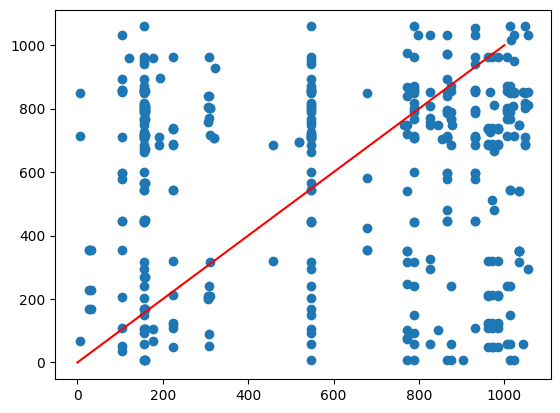

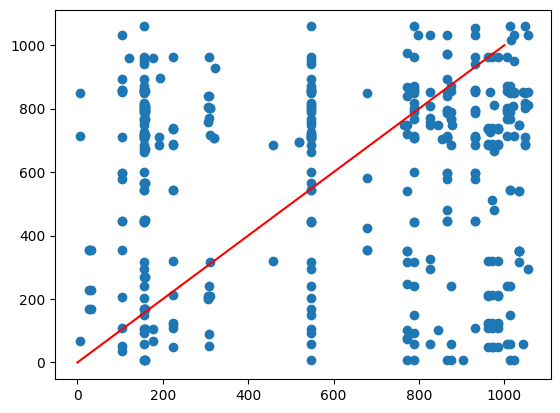

In [86]:
_ = plotInducedByModelNumber(subnet_df=STRONG_DF, significance=1e-4)
plt.figure()
SIGNIFICANT_REFERENCE_NAMES = plotInducedByModelNumber(subnet_df=STRONG_DF, significance=1e-4,
            xlim=None)

In [23]:
len(SIGNIFICANT_REFERENCE_NAMES)

55

# CDF of Number of targets per reference

# Analysis

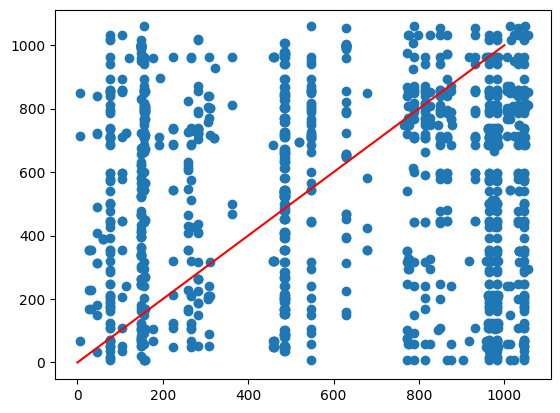

In [24]:
# Scatter plot of subnets
xvals = [extractBiomodelNum(m) for m in STRONG_DF['reference_name']]
yvals = [extractBiomodelNum(m) for m in STRONG_DF['target_name']]
plt.scatter(xvals, yvals)
#plt.xlim([0, 300])
#plt.ylim([0, 300])
plt.plot([0,1000], [0, 1000], c='red')

Above the red line are target odels that embed an existing reference model. Below the red line indicate common motif without reuse. The dots below indicate opportunities for reuse.

In [26]:
print(makeAntimony('BIOMD0000000150'))

BIOMD0000000150: 4 species, 2 reactions
  Binding: CyclinA + Cdk2 -> CDK2cycA
  Activation: CDK2cycA -> CDK2cycA_star_


In [27]:
# Print all of the reference models that appear in targets
for name in SIGNIFICANT_REFERENCE_NAMES:
    result = makeAntimony(name)
    if result is not None:
        print(result + '\n\n')

BIOMD0000000006: 4 species, 3 reactions
  Reaction1: EmptySet -> z
  Reaction2: u -> EmptySet
  Reaction3: z -> u


BIOMD0000000027: 5 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000031: 6 species, 4 reactions
  v1: M -> Mp
  v2: Mp -> Mpp
  v3: Mpp -> Mp
  v4: Mp -> M


BIOMD0000000104: 6 species, 2 reactions
  reaction_0: species_0 -> species_1
  reaction_1: species_1 -> species_4


BIOMD0000000121: 6 species, 5 reactions
  reaction_0000001: c3 -> c2
  reaction_0000002: c2 -> c1
  reaction_0000003: c1 -> o
  reaction_0000004: o -> i
  reaction_0000005: c1 -> i


BIOMD0000000156: 3 species, 5 reactions
  R1:  -> x
  R3: x -> 
  R4:  -> y0
  R5: y0 -> y
  R6: y -> 


BIOMD0000000157: 3 species, 6 reactions
  R1:  -> x
  R2: x -> 
  R3: x -> 
  R4:  -> y0
  R5: y0 -> y
  R6: y -> 


BIOMD0000000158: 3 species, 6 reactions
  R1:  -> x
  R2: x -> 
  R3: x -> 
  R4:  -> y0
  R5: y0 -> y
  R6: y -> 


BIOMD0000000159: 3 species, 6 reactions
  

# Notes

1. BioModels w/o significance
   1. Basic scatter
   2. Most induced reference and what it is
1. Significance evaluation
   1. Heat map.
   2. Little difference between weak and strong identity in terms of significance levels. How about subnets?
   3. Approximate significance with model size.
1. BioModels with significance
    1. Interesting reference models and where reused
        1. Double phos
        2. SIR
        3. MERK model
    1. Interesting targets -- lots of reference
1. Oscillator